In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /content/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /content/rps-test-set.zip

--2021-06-10 10:21:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/content/rps.zip’

/content/rps.zip    100%[===================>] 191.38M  93.2MB/s    in 2.1s    

2021-06-10 10:21:05 (93.2 MB/s) - ‘/content/rps.zip’ saved [200682221/200682221]

--2021-06-10 10:21:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to

In [ ]:
import os
import zipfile
import random
import cv2
import numpy as np
import pandas as pd
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten
from keras.applications.resnet import ResNet50


In [ ]:
local_zip = '/content/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

local_zip = '/content/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
rock_dir = os.path.join('/content/rps/rock/')
paper_dir = os.path.join('/content/rps/paper/')
scissors_dir = os.path.join('/content/rps/scissors/')

rock_dir_test = os.path.join('/content/rps-test-set/rock/')
paper_dir_test = os.path.join('/content/rps-test-set/paper/')
scissors_dir_test = os.path.join('/content/rps-test-set/scissors/')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

print('total test rock images:', len(os.listdir(rock_dir_test)))
print('total test paper images:', len(os.listdir(paper_dir_test)))
print('total test scissors images:', len(os.listdir(scissors_dir_test)))


total training rock images: 840
total training paper images: 840
total training scissors images: 840
total test rock images: 124
total test paper images: 124
total test scissors images: 124


In [ ]:
# przygotowanie folderów dla zestawów multi label
rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

rock_files_test = os.listdir(rock_dir_test)
paper_files_test = os.listdir(paper_dir_test)
scissors_files_test = os.listdir(scissors_dir_test)

if not os.path.exists('/content/multilabel_data'):
    os.makedirs('/content/multilabel_data')
    os.makedirs('/content/multilabel_data/rr')
    os.makedirs('/content/multilabel_data/rp')
    os.makedirs('/content/multilabel_data/rs')
    os.makedirs('/content/multilabel_data/pr')
    os.makedirs('/content/multilabel_data/pp')
    os.makedirs('/content/multilabel_data/ps')
    os.makedirs('/content/multilabel_data/sr')
    os.makedirs('/content/multilabel_data/sp')
    os.makedirs('/content/multilabel_data/ss')
if not os.path.exists('/content/multilabel_test_data'):
    os.makedirs('/content/multilabel_test_data')
    os.makedirs('/content/multilabel_test_data/rr')
    os.makedirs('/content/multilabel_test_data/rp')
    os.makedirs('/content/multilabel_test_data/rs')
    os.makedirs('/content/multilabel_test_data/pr')
    os.makedirs('/content/multilabel_test_data/pp')
    os.makedirs('/content/multilabel_test_data/ps')
    os.makedirs('/content/multilabel_test_data/sr')
    os.makedirs('/content/multilabel_test_data/sp')
    os.makedirs('/content/multilabel_test_data/ss')


In [ ]:
# zestaw train
random_rock_images = random.sample(os.listdir(rock_dir), 300)
random_rock_images2 = random.sample(os.listdir(rock_dir), 300)
random_paper_images = random.sample(os.listdir(paper_dir), 300)
random_paper_images2 = random.sample(os.listdir(paper_dir), 300)
random_scissors_images = random.sample(os.listdir(scissors_dir), 300)
random_scissors_images2 = random.sample(os.listdir(scissors_dir), 300)

# zestaw test
random_rock_images_test = random.sample(os.listdir(rock_dir_test), 100)
random_rock_images2_test = random.sample(os.listdir(rock_dir_test), 100)
random_paper_images_test = random.sample(os.listdir(paper_dir_test), 100)
random_paper_images2_test = random.sample(os.listdir(paper_dir_test), 100)
random_scissors_images_test = random.sample(os.listdir(scissors_dir_test), 100)
random_scissors_images2_test = random.sample(os.listdir(scissors_dir_test), 100)


print(random_rock_images)
print(random_rock_images2)
print(random_paper_images)
print(random_scissors_images)

['rock06ck02-034.png', 'rock04-043.png', 'rock07-k03-117.png', 'rock01-093.png', 'rock05ck01-044.png', 'rock01-002.png', 'rock06ck02-003.png', 'rock05ck01-097.png', 'rock07-k03-106.png', 'rock03-060.png', 'rock02-106.png', 'rock05ck01-028.png', 'rock02-107.png', 'rock05ck01-013.png', 'rock02-088.png', 'rock05ck01-051.png', 'rock02-015.png', 'rock06ck02-015.png', 'rock06ck02-100.png', 'rock07-k03-018.png', 'rock03-056.png', 'rock04-037.png', 'rock02-087.png', 'rock01-083.png', 'rock07-k03-059.png', 'rock06ck02-083.png', 'rock02-113.png', 'rock01-089.png', 'rock01-012.png', 'rock01-094.png', 'rock01-005.png', 'rock05ck01-039.png', 'rock05ck01-098.png', 'rock01-067.png', 'rock06ck02-095.png', 'rock02-075.png', 'rock06ck02-035.png', 'rock03-053.png', 'rock05ck01-016.png', 'rock04-031.png', 'rock01-022.png', 'rock06ck02-054.png', 'rock05ck01-033.png', 'rock04-024.png', 'rock03-073.png', 'rock03-027.png', 'rock01-053.png', 'rock02-021.png', 'rock03-071.png', 'rock02-061.png', 'rock04-012.png

In [ ]:
# przygotowanie zestawów multi label
#################################### TRAIN #####################################

# ROCK-ROCK
for i in range(len(random_rock_images)):
    img1 = cv2.imread(rock_dir+random_rock_images[i])
    img2 = cv2.imread(rock_dir+random_rock_images2[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/rr/', 'rockrock-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/rr/rockrock-{}.txt".format(i), 'w+') as file:
#      file.write("rock\nrock")
#    file.close() 

# ROCK-PAPER
for i in range(len(random_rock_images)):
    img1 = cv2.imread(rock_dir+random_rock_images [i])
    img2 = cv2.imread(paper_dir+random_paper_images [i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/rp/', 'rockpaper-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/rp/rockpaper-{}.txt".format(i), 'w+') as file:
#      file.write("rock\npaper")
#    file.close() 
# ROCK-SCISSORS
for i in range(len(random_rock_images)):
    img1 = cv2.imread(rock_dir+random_rock_images[i])
    img2 = cv2.imread(scissors_dir+random_scissors_images[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/rs/', 'rockscissors-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/rs/rockscissors-{}.txt".format(i), 'w+') as file:
#      file.write("rock\nscissors")
#    file.close() 
# PAPER-ROCK
for i in range(len(random_rock_images)):
    img1 = cv2.imread(paper_dir+random_paper_images[i])
    img2 = cv2.imread(rock_dir+random_rock_images[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/pr/', 'paperrock-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/pr/paperrock-{}.txt".format(i), 'w+') as file:
#      file.write("paper\nrock")
#    file.close() 
# PAPER-PAPER
for i in range(len(random_rock_images)):
    img1 = cv2.imread(paper_dir+random_paper_images[i])
    img2 = cv2.imread(paper_dir+random_paper_images2[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/pp/', 'paperpaper-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/pp/paperpaper-{}.txt".format(i), 'w+') as file:
#      file.write("paper\npaper")
#    file.close() 
# PAPER-SCISSORS
for i in range(len(random_rock_images)):
    img1 = cv2.imread(paper_dir+random_paper_images[i])
    img2 = cv2.imread(scissors_dir+random_scissors_images[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/ps/', 'paperscissors-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/ps/paperscissors-{}.txt".format(i), 'w+') as file:
#      file.write("paper\nscissors")
#    file.close() 
# SCISSORS-ROCK
for i in range(len(random_rock_images)):
    img1 = cv2.imread(scissors_dir+random_scissors_images[i])
    img2 = cv2.imread(rock_dir+random_rock_images[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/sr/', 'scissorsrock-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/sr/scissorsrock-{}.txt".format(i), 'w+') as file:
#      file.write("scissors\nrock")
#    file.close() 
# SCISSORS-PAPER
for i in range(len(random_rock_images)):
    img1 = cv2.imread(scissors_dir+random_scissors_images[i])
    img2 = cv2.imread(paper_dir+random_paper_images[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/sp/', 'scissorspaper-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/sp/scissorspaper-{}.txt".format(i), 'w+') as file:
#      file.write("scissors\npaper")
#    file.close() 
# SCISSORS-SCISSORS
for i in range(len(random_rock_images)):
    img1 = cv2.imread(scissors_dir+random_scissors_images[i])
    img2 = cv2.imread(scissors_dir+random_scissors_images2[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)#
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_data/ss/', 'scissorsscissors-{}.png'.format(i)), concat)
#    with open("/content/multilabel_data/ss/scissorsscissors-{}.txt".format(i), 'w+') as file:
#      file.write("scissors\nscissors")
#    file.close() 
print("Zbiór multilabel train utworzony")


####################################### TEST ###################################
# ROCK-ROCK
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(rock_dir_test+random_rock_images_test[i])
    img2 = cv2.imread(rock_dir_test+random_rock_images2_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/rr/', 'testrockrock-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/rr/testrockrock-{}.txt".format(i), 'w+') as file:
#      file.write("rock\nrock")
#    file.close() 
# ROCK-PAPER
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(rock_dir_test+random_rock_images_test[i])
    img2 = cv2.imread(paper_dir_test+random_paper_images_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/rp/', 'testrockpaper-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/rp/testrockpaper-{}.txt".format(i), 'w+') as file:
#      file.write("rock\npaper")
#    file.close()
# ROCK-SCISSORS
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(rock_dir_test+random_rock_images_test[i])
    img2 = cv2.imread(scissors_dir_test+random_scissors_images_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/rs/', 'testrockscissors-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/rs/testrockscissors-{}.txt".format(i), 'w+') as file:
#      file.write("rock\nscissors")
#    file.close()
# PAPER-ROCK
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(paper_dir_test+random_paper_images_test[i])
    img2 = cv2.imread(rock_dir_test+random_rock_images_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/pr/', 'testpaperrock-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/pr/testpaperrock-{}.txt".format(i), 'w+') as file:
#        file.write("paper\nrock")
#    file.close()
# PAPER-PAPER
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(paper_dir_test+random_paper_images_test[i])
    img2 = cv2.imread(paper_dir_test+random_paper_images2_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/pp/', 'testpaperpaper-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/pp/testpaperpaper-{}.txt".format(i), 'w+') as file:
#      file.write("paper\paper")
#    file.close()
# PAPER-SCISSORS
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(paper_dir_test+random_paper_images_test[i])
    img2 = cv2.imread(scissors_dir_test+random_scissors_images_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/ps/', 'testpaperscissors-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/ps/testpaperscissors-{}.txt".format(i), 'w+') as file:
#      file.write("paper\nscissors")
#    file.close()
# SCISSORS-ROCK
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(scissors_dir_test+random_scissors_images_test[i])
    img2 = cv2.imread(rock_dir_test+random_rock_images_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/sr/', 'testscissorsrock-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/sr/testscissorsrock-{}.txt".format(i), 'w+') as file:
#      file.write("scissors\nrock")
#    file.close()
# SCISSORS-PAPER
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(scissors_dir_test+random_scissors_images_test[i])
    img2 = cv2.imread(paper_dir_test+random_paper_images_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/sp/', 'testscissorspaper-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/sp/testscissorspaper-{}.txt".format(i), 'w+') as file:
#      file.write("scissors\npaper")
#    file.close()
# SCISSORS-SCISSORS
for i in range(len(random_rock_images_test)):
    img1 = cv2.imread(scissors_dir_test+random_scissors_images_test[i])
    img2 = cv2.imread(scissors_dir_test+random_scissors_images2_test[i])
    concat = cv2.hconcat([img1, img2])
    #cv2.imshow('test1', img1)
    #cv2.imshow('test2', img2)
    #cv2.imshow('CONCAT', concat)
    cv2.imwrite(os.path.join('/content/multilabel_test_data/ss/', 'testscissorsscissors-{}.png'.format(i)), concat)
#    with open("/content/multilabel_test_data/ss/testscissorsscissors-{}.txt".format(i), 'w+') as file:
#      file.write("scissors\scissors")
#    file.close()

print("Zbiór multilabel test utworzony")

Zbiór multilabel train utworzony
Zbiór multilabel test utworzony


In [ ]:
def load_data(df):
    
    trainX, testX, valX = [], [], []
    trainY, testY, valY = [], [], []

    for i in range(len(df)):
        item = df.loc[i][0]
        current_label = np.array((df.loc[i])[1:])

        path = os.path.join('/content/multilabel_data/', item)
        list_of_imgs = [os.path.join(path, file) for file in os.listdir(path)]
        path_test = os.path.join('/content/multilabel_test_data/', item)
        list_of_imgs_test = [os.path.join(path_test, file_test) for file_test in os.listdir(path_test)]

        val_set = list_of_imgs[0::5]
        train_set = set(list_of_imgs[::]).difference(val_set)
        test_set = list_of_imgs_test[::3]

        for file in train_set:
            #img = cv2.imread(file)
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (300, 300))
            trainX.append(img)
            trainY.append(current_label)

        for file in val_set:
            #img = cv2.imread(file)
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (300, 300))
            valX.append(img)
            valY.append(current_label)

        for file in test_set:
            #img = cv2.imread(file)
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (300, 300))
            testX.append(img)
            testY.append(current_label)
    print('Pojedynczy zbior:')
    print("TRAIN:", len(train_set))
    print("VAL:", len(val_set))
    print("TEST:", len(test_set))
    print('----------------------')
    print('Calosc:')
    print("TRAIN:", len(train_set)*9)
    print("VAL:", len(val_set)*9)
    print("TEST:", len(test_set)*9)
    print('----------------------')
    return (np.array(trainX), np.array(trainY), np.array(testX), 
    np.array(testY), np.array(valX), np.array(valY))

In [ ]:
df = pd.read_csv('/content/labels.csv')
trainX, trainY, testX, testY, valX, valY = load_data(df)

Pojedynczy zbior:
TRAIN: 240
VAL: 60
TEST: 34
----------------------
Calosc:
TRAIN: 2160
VAL: 540
TEST: 306
----------------------


In [ ]:
trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
valX = valX.astype(np.float32)

trainY = trainY.astype(np.float32)
testY = testY.astype(np.float32)
valY = valY.astype(np.float32)

#trainX = np.asarray(trainY).astype('float32').reshape((-1,1))
#testX = np.asarray(testY).astype('float32').reshape((-1,1))
#valX = np.asarray(valY).astype('float32').reshape((-1,1))

#trainX = trainX.map(lambda x_text, x_label: (x_text, tf.expand_dims(x_label, -1)))
#testX = testX.map(lambda x_text, x_label: (x_text, tf.expand_dims(x_label, -1)))


In [ ]:
img = Input(shape = (300, 300, 3))

model = ResNet50(include_top=False, 
                    weights='imagenet', 
                    input_tensor=img, 
                    input_shape=None, 
                    pooling='avg')
final_layer = model.layers[-1].output

dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
output_layer = Dense(3, activation = 'sigmoid')(dense_layer_1)

model = Model(inputs=img, outputs = output_layer)

In [ ]:
import tensorflow as tf
checkpoint_filepath = '/content/rps_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.summary()

In [ ]:
model.fit(trainX, trainY, batch_size = 32, epochs = 8, callbacks=[model_checkpoint_callback])

Epoch 1/8
68/68 [==============================] - 103s 1s/step - loss: 0.1956 - accuracy: 0.5789
Epoch 2/8
68/68 [==============================] - 85s 1s/step - loss: 6.6799e-04 - accuracy: 0.5836
Epoch 3/8
68/68 [==============================] - 85s 1s/step - loss: 1.4449e-04 - accuracy: 0.6458
Epoch 4/8
68/68 [==============================] - 85s 1s/step - loss: 1.0896e-04 - accuracy: 0.6548
Epoch 5/8
68/68 [==============================] - 85s 1s/step - loss: 0.1263 - accuracy: 0.6345
Epoch 6/8
68/68 [==============================] - 85s 1s/step - loss: 0.0076 - accuracy: 0.7224
Epoch 7/8
68/68 [==============================] - 85s 1s/step - loss: 2.2676e-04 - accuracy: 0.6652
Epoch 8/8
68/68 [==============================] - 85s 1s/step - loss: 1.2083e-04 - accuracy: 0.6745


EWALUACJA MODELU

In [ ]:
results = model.evaluate(trainX, trainY, batch_size=32)
print("train loss, train accuracy:", results)
results1 = model.evaluate(testX, testY, batch_size=32)
print("test loss, test accuracy:", results1)
print("-------------------------------------------------------------")
print("Dokładność modelu na treningowym zbiorze wynosi: %.2f "% results[1])
print("Dokładność modelu na testowym zbiorze wynosi: %.2f"% results1[1])
print("-------------------------------------------------------------")

# zapis i pobranie modelu
#model.save('/content/rps_model')
#!zip -r /content/rps_model.zip /content/rps_model

#from google.colab import files
#files.download("/content/rps_model.zip")

68/68 [==============================] - 27s 395ms/step - loss: 8.6395e-06 - accuracy: 0.7481
train loss, train accuracy: [8.639544830657542e-06, 0.7481481432914734]
10/10 [==============================] - 4s 380ms/step - loss: 0.0152 - accuracy: 0.7255
test loss, test accuracy: [0.015217399224638939, 0.7254902124404907]
-------------------------------------------------------------
Dokładność modelu na treningowym zbiorze wynosi: 0.75 
Dokładność modelu na testowym zbiorze wynosi: 0.73
-------------------------------------------------------------


-------PREDYKCJA DLA ZBIORU TRENINGOWEGO-------
Labels: rock, paper, scissors
Labels: [1. 0. 0.]
Prediction: ['rock']


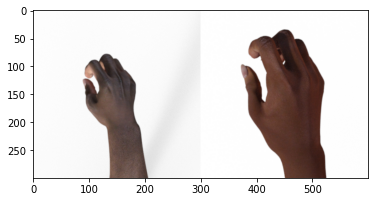

Labels: rock, paper, scissors
Labels: [1. 1. 0.]
Prediction: ['rock', 'paper']


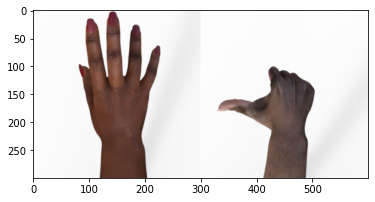

Labels: rock, paper, scissors
Labels: [1. 0. 1.]
Prediction: ['rock', 'scissors']


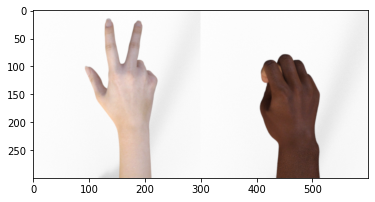

------PREDYKCJA DLA ZBIORU TESTOWEGO-------
Labels: rock, paper, scissors
Labels: [1. 1. 0.]
Prediction: ['rock', 'paper']


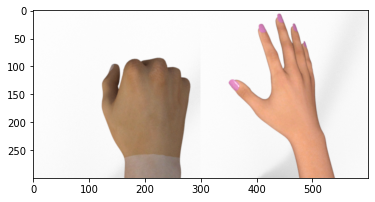

Labels: rock, paper, scissors
Labels: [0. 1. 1.]
Prediction: ['paper', 'scissors']


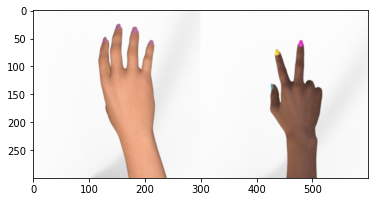

Labels: rock, paper, scissors
Labels: [0. 0. 1.]
Prediction: ['scissors']


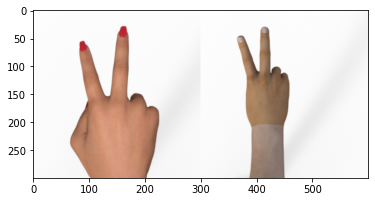

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
categories = ['rock', 'paper', 'scissors']

# wybor folderu ze zdjeciami
ml_dir1 = os.path.join('/content/multilabel_data/rr/')
ml_dir2 = os.path.join('/content/multilabel_data/pr/')
ml_dir3 = os.path.join('/content/multilabel_data/sr/')

ml_dir_test1 = os.path.join('/content/multilabel_test_data/rp/')
ml_dir_test2 = os.path.join('/content/multilabel_test_data/ps/')
ml_dir_test3 = os.path.join('/content/multilabel_test_data/ss/')


print('-------PREDYKCJA DLA ZBIORU TRENINGOWEGO-------')
next_rock = [os.path.join(ml_dir1, fname) 
                for fname in os.listdir(ml_dir1)[0:1]]
next_paper = [os.path.join(ml_dir2, fname) 
                for fname in os.listdir(ml_dir2)[0:1]]
next_scissors = [os.path.join(ml_dir3, fname) 
                for fname in os.listdir(ml_dir3)[0:1]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    #print(img_path)
    image_res = cv2.resize((cv2.imread(img_path, 1)), (300, 300))
    image_dim = np.expand_dims(image_res, axis = 0)
    prediction = np.round(model.predict(image_dim)[0])
    print("Labels: rock, paper, scissors")
    print("Labels:", prediction)
    labels = [categories[i] for i, current_prediction in enumerate(prediction) if current_prediction == 1]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    print('Prediction:', labels)
    plt.show()
print('------PREDYKCJA DLA ZBIORU TESTOWEGO-------')
next_rock_test = [os.path.join(ml_dir_test1, fname) 
                for fname in os.listdir(ml_dir_test1)[0:1]]
next_paper_test = [os.path.join(ml_dir_test2, fname) 
                for fname in os.listdir(ml_dir_test2)[0:1]]
next_scissors_test = [os.path.join(ml_dir_test3, fname) 
                for fname in os.listdir(ml_dir_test3)[0:1]]

for i, img_path in enumerate(next_rock_test+next_paper_test+next_scissors_test):
    #print(img_path)
    image_res = cv2.resize((cv2.imread(img_path, 1)), (300, 300))
    image_dim = np.expand_dims(image_res, axis = 0)
    prediction = np.round(model.predict(image_dim)[0])
    print("Labels: rock, paper, scissors")
    print("Labels:", prediction)
    labels = [categories[i] for i, current_prediction in enumerate(prediction) if current_prediction == 1]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    print('Prediction:', labels)
    plt.show()